# Healthcare Disease Prediction System
## Multi-Class Text Classification for Disease Prediction from Symptoms

---

### Project Overview
This notebook implements a comprehensive machine learning pipeline for predicting diseases based on textual symptom descriptions. We will:

1. **Exploratory Data Analysis (EDA)**: Understand the dataset structure and characteristics
2. **Data Preprocessing**: Clean and prepare text data for modeling
3. **Feature Engineering**: Convert text to numerical features using TF-IDF
4. **Model Training**: Train multiple ML models (Logistic Regression, SVM, XGBoost, etc.)
5. **Model Evaluation**: Compare performance across different models
6. **Model Persistence**: Save best models for production use

**Dataset**: 1,200 symptom descriptions across 24 different diseases (50 samples per disease)

---
## 1. Import Required Libraries

In [4]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
from collections import Counter

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

# Model Persistence
import joblib
import pickle

# Visualization
from wordcloud import WordCloud

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Random Seed for Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")

All libraries imported successfully!


---
## 2. Download NLTK Resources

In [5]:
# Download required NLTK data
nltk_resources = ['punkt', 'stopwords', 'wordnet', 'omw-1.4', 'averaged_perceptron_tagger']

for resource in nltk_resources:
    try:
        nltk.download(resource, quiet=True)
    except:
        pass

print("NLTK resources downloaded successfully!")

NLTK resources downloaded successfully!


---
## 3. Load Dataset

In [6]:
# Load the dataset
df = pd.read_csv('../dataset/Symptom2Disease.csv')

print("Dataset loaded successfully!")
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Samples: {len(df)}")
print(f"Number of Features: {len(df.columns)}")

# Display first few rows
df.head()

Dataset loaded successfully!

Dataset Shape: (1200, 3)
Number of Samples: 1200
Number of Features: 3


,Unnamed: 0,label,text
0,0,Psoriasis,"I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is r..."
1,1,Psoriasis,"My skin has been peeling, especially on my knees, elbows, and scalp. This peeling is often accom..."
2,2,Psoriasis,"I have been experiencing joint pain in my fingers, wrists, and knees. The pain is often achy and..."
3,3,Psoriasis,"There is a silver like dusting on my skin, especially on my lower back and scalp. This dusting i..."
4,4,Psoriasis,"My nails have small dents or pits in them, and they often feel inflammatory and tender to the to..."


---
## 4. Exploratory Data Analysis (EDA)

### 4.1 Basic Information

In [7]:
# Dataset information
print("\nDataset Structure:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nColumn Names:")
print(df.columns.tolist())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nData Types:")
print(df.dtypes)


Dataset Structure:
<class 'pandas.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  1200 non-null   int64
 1   label       1200 non-null   str  
 2   text        1200 non-null   str  
dtypes: int64(1), str(2)
memory usage: 28.3 KB
None

Statistical Summary:
        Unnamed: 0
count  1200.000000
mean    149.500000
std      86.638166
min       0.000000
25%      74.750000
50%     149.500000
75%     224.250000
max     299.000000

Column Names:
['Unnamed: 0', 'label', 'text']

Missing Values:
Unnamed: 0    0
label         0
text          0
dtype: int64

Data Types:
Unnamed: 0    int64
label           str
text            str
dtype: object


### 4.2 Target Variable Analysis

In [45]:
# Analyze target variable (diseases)
print(f"\nNumber of Unique Diseases: {df['label'].nunique()}")

print("\nDisease Distribution:")
disease_counts = df['label'].value_counts().sort_index()
print(disease_counts)

print(f"\nDataset is {'BALANCED' if disease_counts.nunique() == 1 else 'IMBALANCED'}")


Number of Unique Diseases: 24

Disease Distribution:
label
Acne                               50
Arthritis                          50
Bronchial Asthma                   50
Cervical spondylosis               50
Chicken pox                        50
Common Cold                        50
Dengue                             50
Dimorphic Hemorrhoids              50
Fungal infection                   50
Hypertension                       50
Impetigo                           50
Jaundice                           50
Malaria                            50
Migraine                           50
Pneumonia                          50
Psoriasis                          50
Typhoid                            50
Varicose Veins                     50
allergy                            50
diabetes                           50
drug reaction                      50
gastroesophageal reflux disease    50
peptic ulcer disease               50
urinary tract infection            50
Name: count, dtype: int64

D

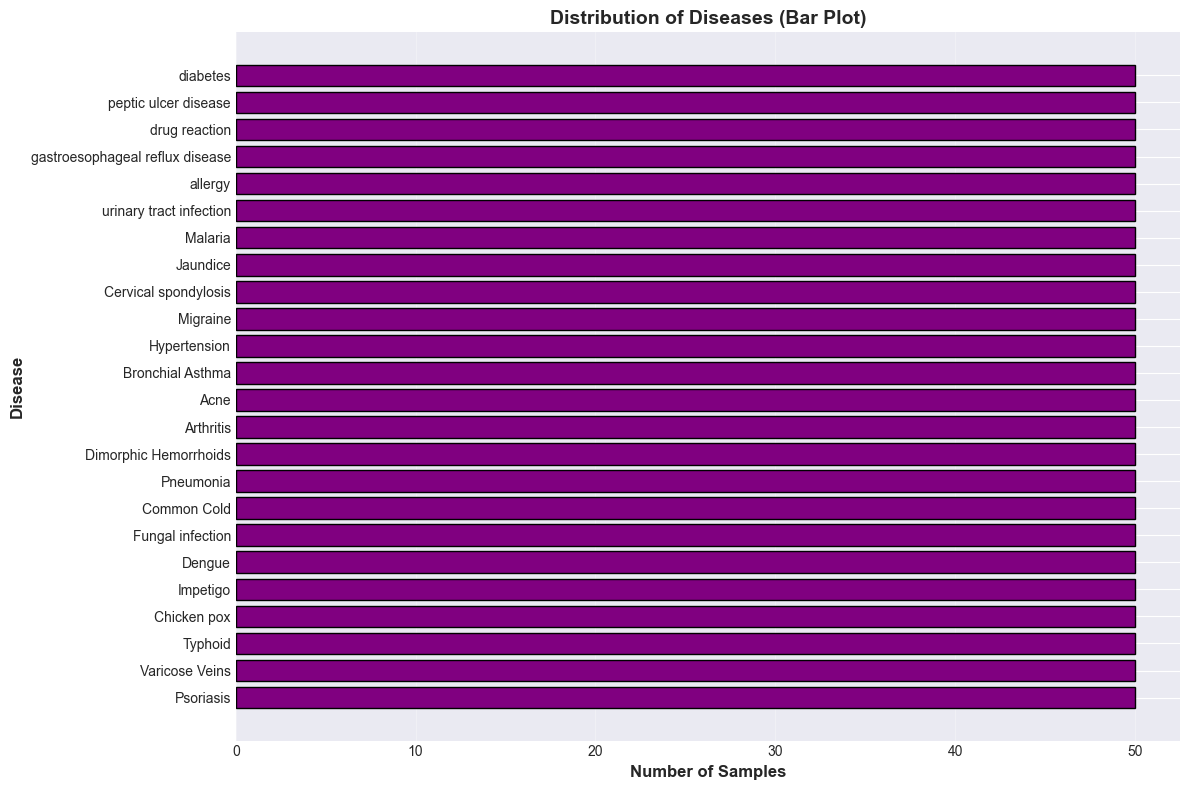

In [47]:
# Visualize disease distribution
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

# Bar plot
disease_counts = df['label'].value_counts()
# Make axes indexable (so axes[0] works below) and plot
axes = [axes]
axes[0].barh(disease_counts.index, disease_counts.values, color='purple', edgecolor='black')
axes[0].set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Disease', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Diseases (Bar Plot)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 Text Length Analysis

In [9]:
# Analyze text lengths
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

print("\nCharacter Length Statistics:")
print(df['text_length'].describe())

print("\nWord Count Statistics:")
print(df['word_count'].describe())


Character Length Statistics:
count    1200.000000
mean      171.876667
std        35.481506
min        60.000000
25%       147.750000
50%       170.000000
75%       193.000000
max       317.000000
Name: text_length, dtype: float64

Word Count Statistics:
count    1200.000000
mean       30.725000
std         6.707225
min        12.000000
25%        26.000000
50%        30.000000
75%        35.000000
max        55.000000
Name: word_count, dtype: float64


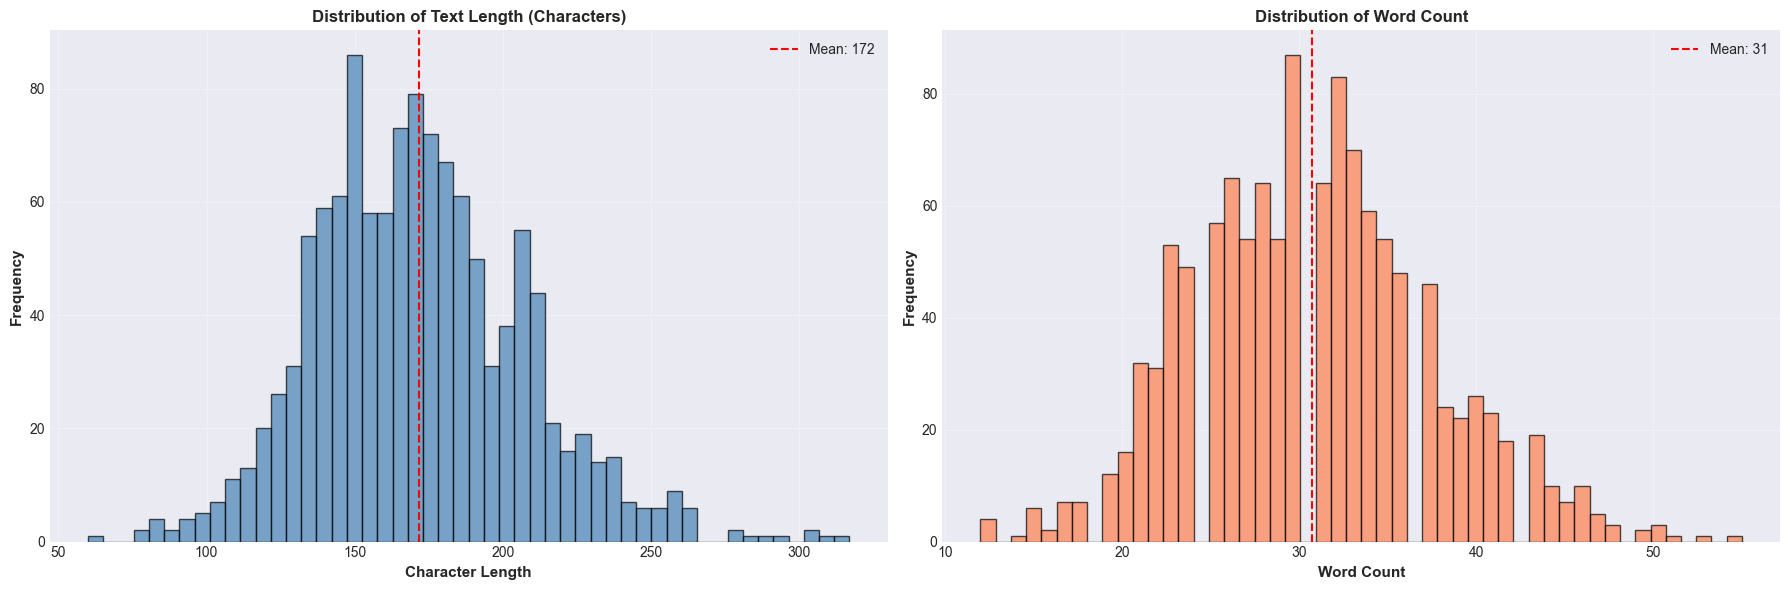

In [51]:
# Visualize text lengths
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Character length distribution
axes[0].hist(df['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Character Length', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribution of Text Length (Characters)', fontsize=12, fontweight='bold')
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f"Mean: {df['text_length'].mean():.0f}")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Word count distribution
axes[1].hist(df['word_count'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Distribution of Word Count', fontsize=12, fontweight='bold')
axes[1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f"Mean: {df['word_count'].mean():.0f}")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 4.4 Word Cloud Visualization

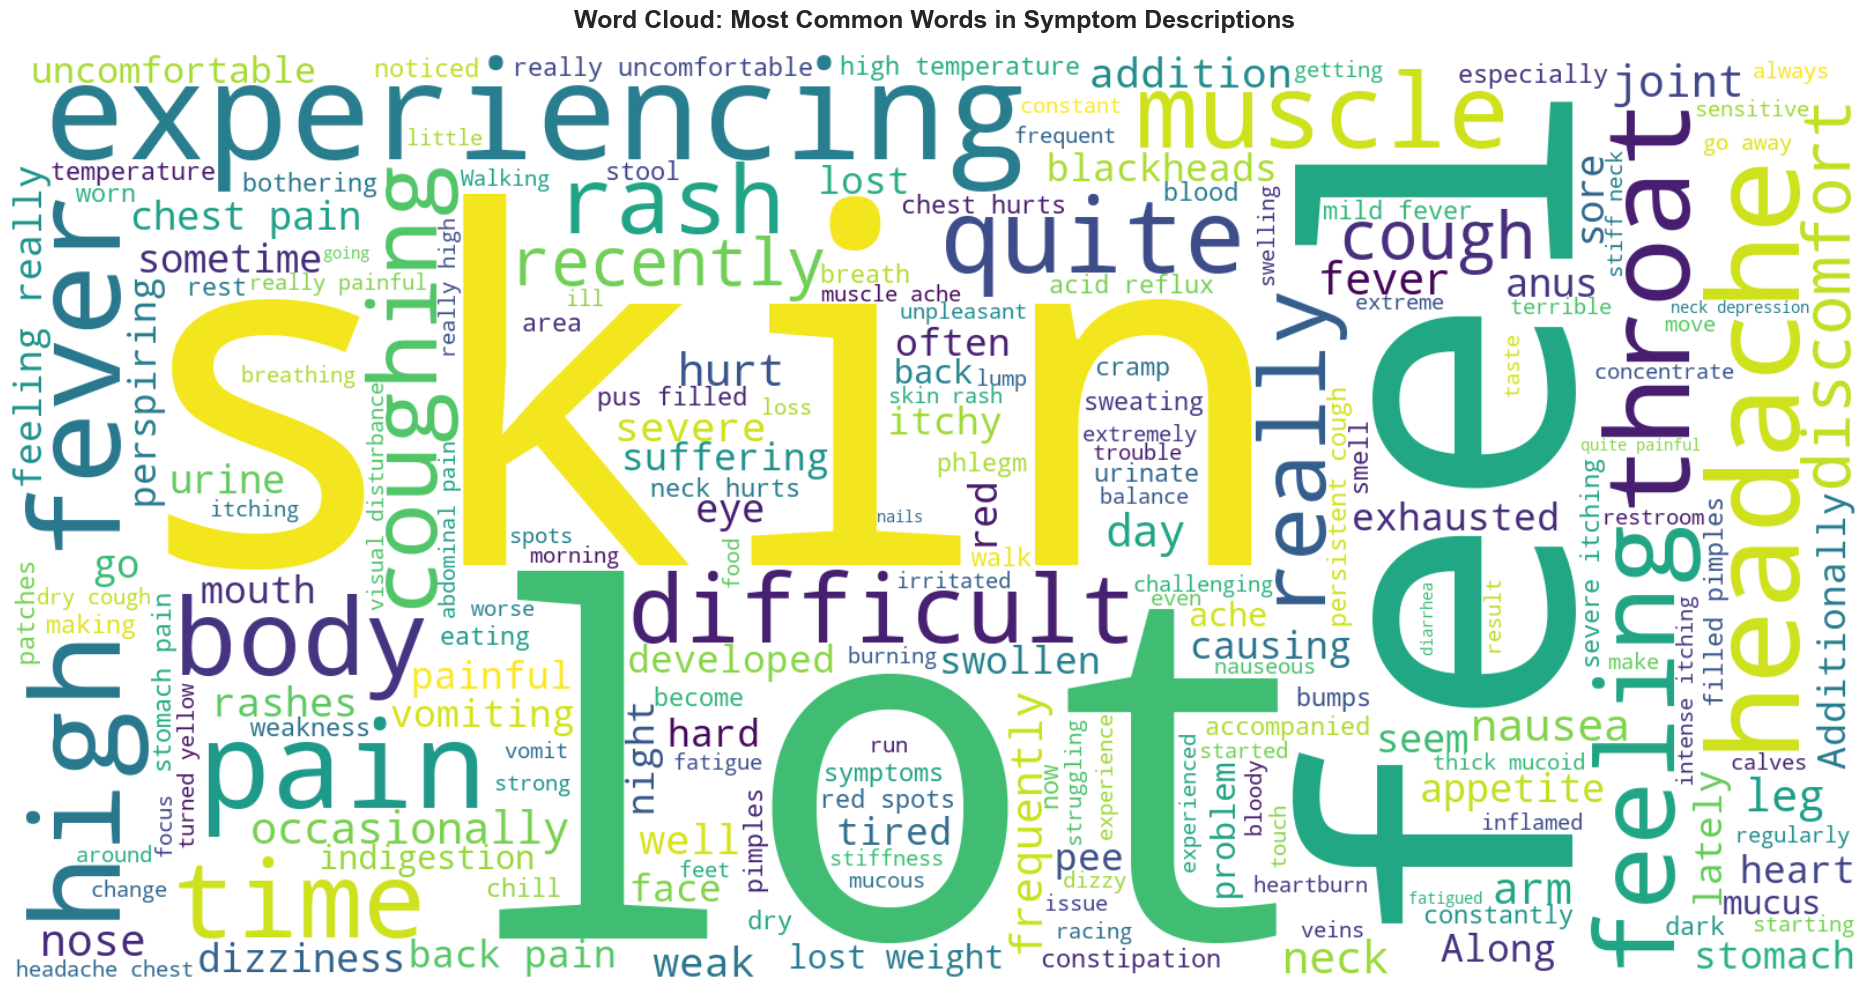

In [52]:
# Create word cloud for overall corpus
all_text = ' '.join(df['text'].values)

wordcloud = WordCloud(width=1600, height=800, 
                      background_color='white',
                      colormap='viridis',
                      max_words=200,
                      relative_scaling=0.5,
                      min_font_size=10).generate(all_text)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Most Common Words in Symptom Descriptions', 
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### 4.5 Sample Data Exploration

In [10]:
# Display sample texts for different diseases
sample_diseases = df['label'].unique()[:5]

for disease in sample_diseases:
    sample_text = df[df['label'] == disease].iloc[0]['text']
    print(f"\nDisease: {disease}")
    print(f"Symptoms: {sample_text[:200]}...")
    print("-" * 80)


Disease: Psoriasis
Symptoms: I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches....
--------------------------------------------------------------------------------

Disease: Varicose Veins
Symptoms: I have a rash on my legs that is causing a lot of discomforts. It seems there is a cramp and I can see prominent veins on the calf. Also, I have been feeling very tired and fatigued in the past couple...
--------------------------------------------------------------------------------

Disease: Typhoid
Symptoms: I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a...
--------------------------------------------------------------------------------

Disease: Chicken pox
Symptoms: I've been experiencing intense itching all over my skin, and it's driving me cr

---
## 5. Data Preprocessing

Clean and prepare text data for machine learning models.

### 5.1 Text Cleaning Functions

In [53]:
# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Remove medical-specific words from stopwords (they might be important)
medical_keywords = {'pain', 'fever', 'cough', 'rash', 'itch', 'swell', 'bleed', 
                   'burn', 'ache', 'sore', 'nausea', 'dizzy', 'tired', 'weak'}
stop_words = stop_words - medical_keywords

def clean_text(text):

    """
    Clean and preprocess text data:
    1. Convert to lowercase
    2. Remove special characters and numbers
    3. Tokenize
    4. Remove stopwords
    5. Lemmatize words
    """

    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers (keep letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens 
                     if word not in stop_words and len(word) > 2]
    
    # Join back to string
    return ' '.join(cleaned_tokens)

print("Text cleaning function defined!")

Text cleaning function defined!


### 5.2 Apply Text Cleaning

In [12]:
# Create a copy for preprocessing
df_clean = df.copy()

# Apply cleaning
df_clean['cleaned_text'] = df_clean['text'].apply(clean_text)
print("Text cleaning completed!\n")

# Display cleaned dataset info
print(f"\nCleaned Dataset Shape: {df_clean.shape}")
df_clean.head()

Text cleaning completed!


Cleaned Dataset Shape: (1200, 6)


,Unnamed: 0,label,text,text_length,word_count,cleaned_text
0,0,Psoriasis,"I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is r...",141,28,experiencing skin rash arm leg torso past week red itchy covered dry scaly patch
1,1,Psoriasis,"My skin has been peeling, especially on my knees, elbows, and scalp. This peeling is often accom...",138,23,skin peeling especially knee elbow scalp peeling often accompanied burning stinging sensation
2,2,Psoriasis,"I have been experiencing joint pain in my fingers, wrists, and knees. The pain is often achy and...",148,28,experiencing joint pain finger wrist knee pain often achy throbbing get worse move joint
3,3,Psoriasis,"There is a silver like dusting on my skin, especially on my lower back and scalp. This dusting i...",164,32,silver like dusting skin especially lower back scalp dusting made small scale flake easily scratch
4,4,Psoriasis,"My nails have small dents or pits in them, and they often feel inflammatory and tender to the to...",140,27,nail small dent pit often feel inflammatory tender touch even minor rash arm


### 5.3 Prepare Features and Target

In [13]:
# Prepare features (X) and target (y)
X = df_clean['cleaned_text']
y = df_clean['label']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nData preparation completed!")


Features (X) shape: (1200,)
Target (y) shape: (1200,)

Data preparation completed!


---
## 6. Feature Engineering: TF-IDF Vectorization

Convert text data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency).

In [14]:
# Split data into train and test sets BEFORE vectorization
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\nTrain-test split completed!")


Train-test split completed!


In [15]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,        # Limit to top 1000 features
    ngram_range=(1, 2),       # Use unigrams and bigrams
    min_df=2,                 # Ignore terms that appear in less than 2 documents
    max_df=0.95,              # Ignore terms that appear in more than 95% of documents
    sublinear_tf=True         # Apply sublinear tf scaling
)

# Fit on training data and transform both train and test
X_train = tfidf_vectorizer.fit_transform(X_train_text)
X_test = tfidf_vectorizer.transform(X_test_text)

print("\nTF-IDF vectorization completed!")

print(f"\nTraining features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"\nVocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Feature density: {(X_train.nnz / (X_train.shape[0] * X_train.shape[1])) * 100:.2f}%")

# Show top features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n Sample features:")
print(feature_names[:50])


TF-IDF vectorization completed!

Training features shape: (960, 1000)
Test features shape: (240, 1000)

Vocabulary size: 1000
Feature density: 1.88%

 Sample features:
['abdomen' 'abdominal' 'abdominal pain' 'ability' 'able' 'accompanied'
 'ache' 'ache coughing' 'acid' 'acid reflux' 'acidic' 'acidity' 'activity'
 'addition' 'addition headache' 'addition ive' 'additionally'
 'additionally ive' 'additionally skin' 'additionally walking'
 'aftertaste' 'almost' 'along' 'along chill' 'along headache' 'also'
 'also bothered' 'also cough' 'also coughing' 'also excruciatingly'
 'also experiencing' 'also feel' 'also feeling' 'also headache'
 'also high' 'also lost' 'also lot' 'also noticed' 'also perspiring'
 'also quite' 'also really' 'also sweating' 'always' 'always feel' 'anus'
 'anus quite' 'anus really' 'anything' 'anything muscle' 'appear']


---
## 7. Model Training and Evaluation

Train multiple machine learning models and compare their performance.

### 7.1 Define Evaluation Function

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a machine learning model.
    
    Parameters:
    -----------
    model : sklearn model
        The machine learning model to train
    X_train, X_test : array-like
        Training and test features
    y_train, y_test : array-like
        Training and test labels
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Display results
    print(f"{model_name} - EVALUATION RESULTS")
    print("-" * 80)
    print(f"\nTest Accuracy:      {accuracy*100:.2f}%")
    print(f"Precision (Weighted): {precision*100:.2f}%")
    print(f" Recall (Weighted):    {recall*100:.2f}%")
    print(f" F1-Score (Weighted):  {f1*100:.2f}%")
    print(f"\n Cross-Validation (5-fold):")
    print(f"   Mean Accuracy: {cv_mean*100:.2f}% (+/- {cv_std*100:.2f}%)")
    print(f"   CV Scores: {[f'{score*100:.2f}%' for score in cv_scores]}")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Return metrics dictionary
    return {
        'model_name': model_name,
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'y_pred': y_pred
    }

print(" Evaluation function defined!")

 Evaluation function defined!


### 7.2 Model 1: Logistic Regression

In [17]:
# Logistic Regression
lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    solver='saga',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, 
                            "Logistic Regression")

Logistic Regression - EVALUATION RESULTS
--------------------------------------------------------------------------------

Test Accuracy:      94.58%
Precision (Weighted): 95.38%
 Recall (Weighted):    94.58%
 F1-Score (Weighted):  94.44%

 Cross-Validation (5-fold):
   Mean Accuracy: 95.52% (+/- 0.85%)
   CV Scores: ['96.88%', '95.31%', '94.27%', '95.83%', '95.31%']

Detailed Classification Report:
--------------------------------------------------------------------------------
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       0.91      1.00      0.95        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.80      0.80      0.80        10
                    Common Cold       1.00      1.00      1.00        10
    

### 7.3 Model 2: Linear SVM

In [18]:
# Linear Support Vector Machine
svm_model = LinearSVC(
    C=1.0,
    max_iter=2000,
    dual=False,
    random_state=RANDOM_STATE
)

svm_results = evaluate_model(svm_model, X_train, X_test, y_train, y_test, 
                             "Linear SVM")

Linear SVM - EVALUATION RESULTS
--------------------------------------------------------------------------------

Test Accuracy:      96.67%
Precision (Weighted): 96.95%
 Recall (Weighted):    96.67%
 F1-Score (Weighted):  96.61%

 Cross-Validation (5-fold):
   Mean Accuracy: 95.94% (+/- 1.25%)
   CV Scores: ['96.88%', '95.83%', '93.75%', '97.40%', '95.83%']

Detailed Classification Report:
--------------------------------------------------------------------------------
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       0.91      1.00      0.95        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.90      0.90      0.90        10
                    Common Cold       1.00      1.00      1.00        10
             

### 7.4 Model 3: XGBoost

In [19]:
# Encode labels for XGBoost (requires numeric labels)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Train with encoded labels
xgb_model.fit(X_train, y_train_encoded)
y_pred_encoded = xgb_model.predict(X_test)

# Decode predictions back to original labels
y_pred_xgb = label_encoder.inverse_transform(y_pred_encoded)

# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
precision = precision_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=0)
recall = recall_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=0)

# Cross-validation score
cv_scores = cross_val_score(xgb_model, X_train, y_train_encoded, cv=5, scoring='accuracy')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

# Display results
print(f" XGBoost - EVALUATION RESULTS")
print("-" * 80)
print(f"\n Test Accuracy:      {accuracy*100:.2f}%")
print(f" Precision (Weighted): {precision*100:.2f}%")
print(f" Recall (Weighted):    {recall*100:.2f}%")
print(f" F1-Score (Weighted):  {f1*100:.2f}%")
print(f"\n Cross-Validation (5-fold):")
print(f"   Mean Accuracy: {cv_mean*100:.2f}% (+/- {cv_std*100:.2f}%)")
print(f"   CV Scores: {[f'{score*100:.2f}%' for score in cv_scores]}")

# Classification report
print(f"\n Detailed Classification Report:")
print("-" * 80)
print(classification_report(y_test_encoded, y_pred_encoded, zero_division=0))

# Store results in xgb_results dictionary
xgb_results = {
    'model_name': 'XGBoost',
    'model': xgb_model,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'cv_mean': cv_mean,
    'cv_std': cv_std,
    'y_pred': y_pred_xgb
}

 XGBoost - EVALUATION RESULTS
--------------------------------------------------------------------------------

 Test Accuracy:      88.75%
 Precision (Weighted): 90.01%
 Recall (Weighted):    88.75%
 F1-Score (Weighted):  88.79%

 Cross-Validation (5-fold):
   Mean Accuracy: 87.19% (+/- 1.57%)
   CV Scores: ['86.46%', '84.90%', '86.98%', '89.58%', '88.02%']

 Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       0.62      0.80      0.70        10
           5       1.00      1.00      1.00        10
           6       0.58      0.70      0.64        10
           7       1.00      1.00      1.00        10
           8       1.00      0.90    

### 7.5 Model 4: Random Forest

In [20]:
# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, 
                            "Random Forest")

Random Forest - EVALUATION RESULTS
--------------------------------------------------------------------------------

Test Accuracy:      95.00%
Precision (Weighted): 95.39%
 Recall (Weighted):    95.00%
 F1-Score (Weighted):  94.92%

 Cross-Validation (5-fold):
   Mean Accuracy: 95.10% (+/- 1.30%)
   CV Scores: ['95.83%', '95.83%', '94.79%', '96.35%', '92.71%']

Detailed Classification Report:
--------------------------------------------------------------------------------
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      1.00      1.00        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.80      0.80      0.80        10
                    Common Cold       1.00      1.00      1.00        10
          

### 7.6 Model 5: Multinomial Naive Bayes

In [21]:
# Multinomial Naive Bayes
nb_model = MultinomialNB(
    alpha=1.0
)

nb_results = evaluate_model(nb_model, X_train, X_test, y_train, y_test, 
                            "Multinomial Naive Bayes")

Multinomial Naive Bayes - EVALUATION RESULTS
--------------------------------------------------------------------------------

Test Accuracy:      94.17%
Precision (Weighted): 94.82%
 Recall (Weighted):    94.17%
 F1-Score (Weighted):  94.01%

 Cross-Validation (5-fold):
   Mean Accuracy: 92.92% (+/- 1.34%)
   CV Scores: ['94.79%', '93.23%', '90.62%', '93.23%', '92.71%']

Detailed Classification Report:
--------------------------------------------------------------------------------
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       0.91      1.00      0.95        10
           Cervical spondylosis       0.91      1.00      0.95        10
                    Chicken pox       0.88      0.70      0.78        10
                    Common Cold       0.91      1.00      0.95        10


### 7.7 Model 6: Gradient Boosting

In [22]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=RANDOM_STATE
)

gb_results = evaluate_model(gb_model, X_train, X_test, y_train, y_test, 
                            "Gradient Boosting")

Gradient Boosting - EVALUATION RESULTS
--------------------------------------------------------------------------------

Test Accuracy:      82.92%
Precision (Weighted): 87.05%
 Recall (Weighted):    82.92%
 F1-Score (Weighted):  83.93%

 Cross-Validation (5-fold):
   Mean Accuracy: 83.12% (+/- 1.88%)
   CV Scores: ['81.25%', '81.77%', '81.77%', '85.42%', '85.42%']

Detailed Classification Report:
--------------------------------------------------------------------------------
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      0.70      0.82        10
               Bronchial Asthma       1.00      0.90      0.95        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.62      0.50      0.56        10
                    Common Cold       1.00      1.00      1.00        10
      

### 7.8 Model 7: Neural Network (MLP)

In [23]:
# Multi-Layer Perceptron
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    max_iter=500,
    alpha=0.0001,
    random_state=RANDOM_STATE
)

mlp_results = evaluate_model(mlp_model, X_train, X_test, y_train, y_test, 
                             "Neural Network (MLP)")

Neural Network (MLP) - EVALUATION RESULTS
--------------------------------------------------------------------------------

Test Accuracy:      96.67%
Precision (Weighted): 96.81%
 Recall (Weighted):    96.67%
 F1-Score (Weighted):  96.66%

 Cross-Validation (5-fold):
   Mean Accuracy: 94.69% (+/- 2.24%)
   CV Scores: ['94.79%', '97.40%', '90.62%', '95.83%', '94.79%']

Detailed Classification Report:
--------------------------------------------------------------------------------
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      0.90      0.95        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.90      0.90      0.90        10
                    Common Cold       0.91      1.00      0.95        10
   

---
## 8. Model Comparison

Compare all models and identify the best performer.

In [24]:
# Collect all results
all_results = [
    lr_results,
    svm_results,
    xgb_results,
    rf_results,
    nb_results,
    gb_results,
    mlp_results
]

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Accuracy (%)': f"{result['accuracy']*100:.2f}",
        'Precision (%)': f"{result['precision']*100:.2f}",
        'Recall (%)': f"{result['recall']*100:.2f}",
        'F1-Score (%)': f"{result['f1_score']*100:.2f}",
        'CV Mean (%)': f"{result['cv_mean']*100:.2f}",
        'CV Std (%)': f"{result['cv_std']*100:.2f}"
    }
    for result in all_results
])

comparison_df['Accuracy_numeric'] = comparison_df['Accuracy (%)'].astype(float)

print(" MODEL COMPARISON SUMMARY")
print("-" * 80)
print(comparison_df.to_string(index=False))

 MODEL COMPARISON SUMMARY
--------------------------------------------------------------------------------
                  Model Accuracy (%) Precision (%) Recall (%) F1-Score (%) CV Mean (%) CV Std (%)  Accuracy_numeric
    Logistic Regression        94.58         95.38      94.58        94.44       95.52       0.85             94.58
             Linear SVM        96.67         96.95      96.67        96.61       95.94       1.25             96.67
                XGBoost        88.75         90.01      88.75        88.79       87.19       1.57             88.75
          Random Forest        95.00         95.39      95.00        94.92       95.10       1.30             95.00
Multinomial Naive Bayes        94.17         94.82      94.17        94.01       92.92       1.34             94.17
      Gradient Boosting        82.92         87.05      82.92        83.93       83.12       1.88             82.92
   Neural Network (MLP)        96.67         96.81      96.67        96.66       

### 8.1 Visual Comparison

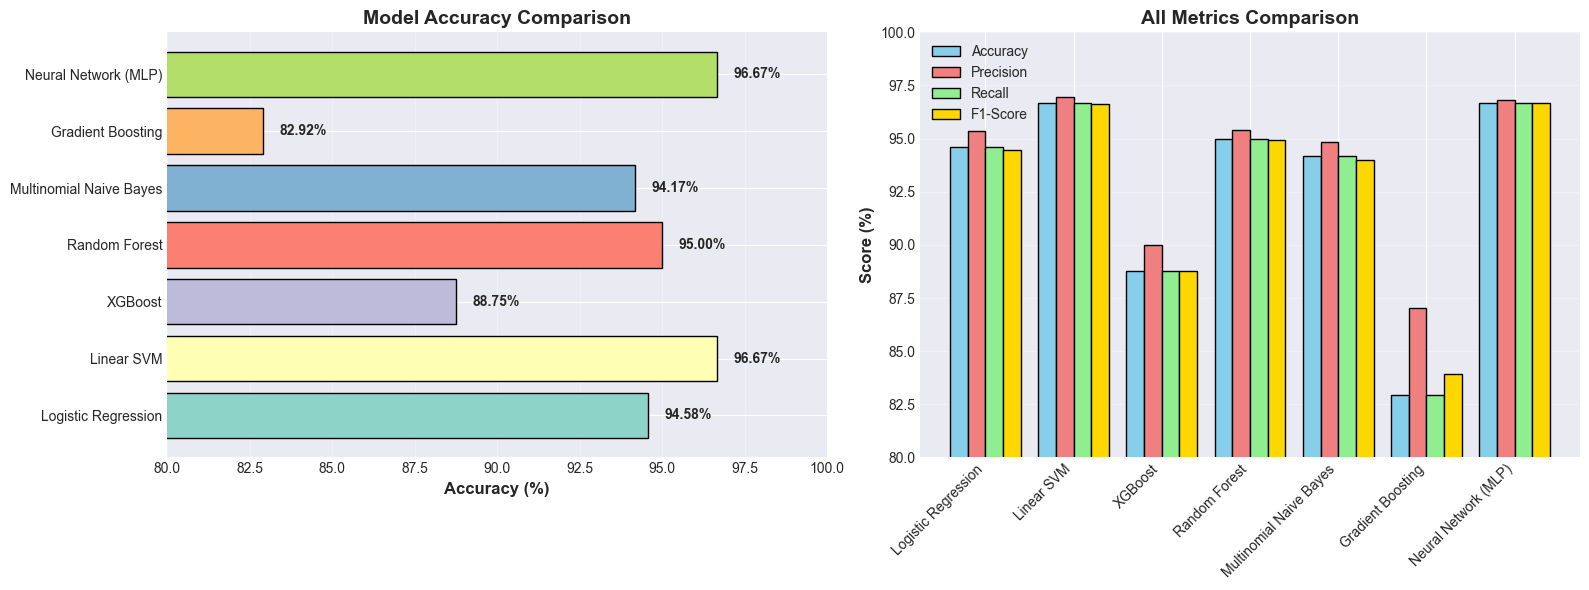

In [30]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for plotting
model_names = [r['model_name'] for r in all_results]
accuracies = [r['accuracy']*100 for r in all_results]
precisions = [r['precision']*100 for r in all_results]
recalls = [r['recall']*100 for r in all_results]
f1_scores = [r['f1_score']*100 for r in all_results]

colors = plt.cm.Set3(range(len(model_names)))

# Plot 1: Accuracy Comparison
axes[0].barh(model_names, accuracies, color=colors, edgecolor='black')
axes[0].set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim([80, 100])
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0].text(v + 0.5, i, f'{v:.2f}%', va='center', fontweight='bold')

# Plot 2: All Metrics Comparison
x = np.arange(len(model_names))
width = 0.2
axes[1].bar(x - 1.5*width, accuracies, width, label='Accuracy', color='skyblue', edgecolor='black')
axes[1].bar(x - 0.5*width, precisions, width, label='Precision', color='lightcoral', edgecolor='black')
axes[1].bar(x + 0.5*width, recalls, width, label='Recall', color='lightgreen', edgecolor='black')
axes[1].bar(x + 1.5*width, f1_scores, width, label='F1-Score', color='gold', edgecolor='black')
axes[1].set_ylabel('Score (%)', fontsize=12, fontweight='bold')
axes[1].set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim([80, 100])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 8.2 Confusion Matrix for Best Model

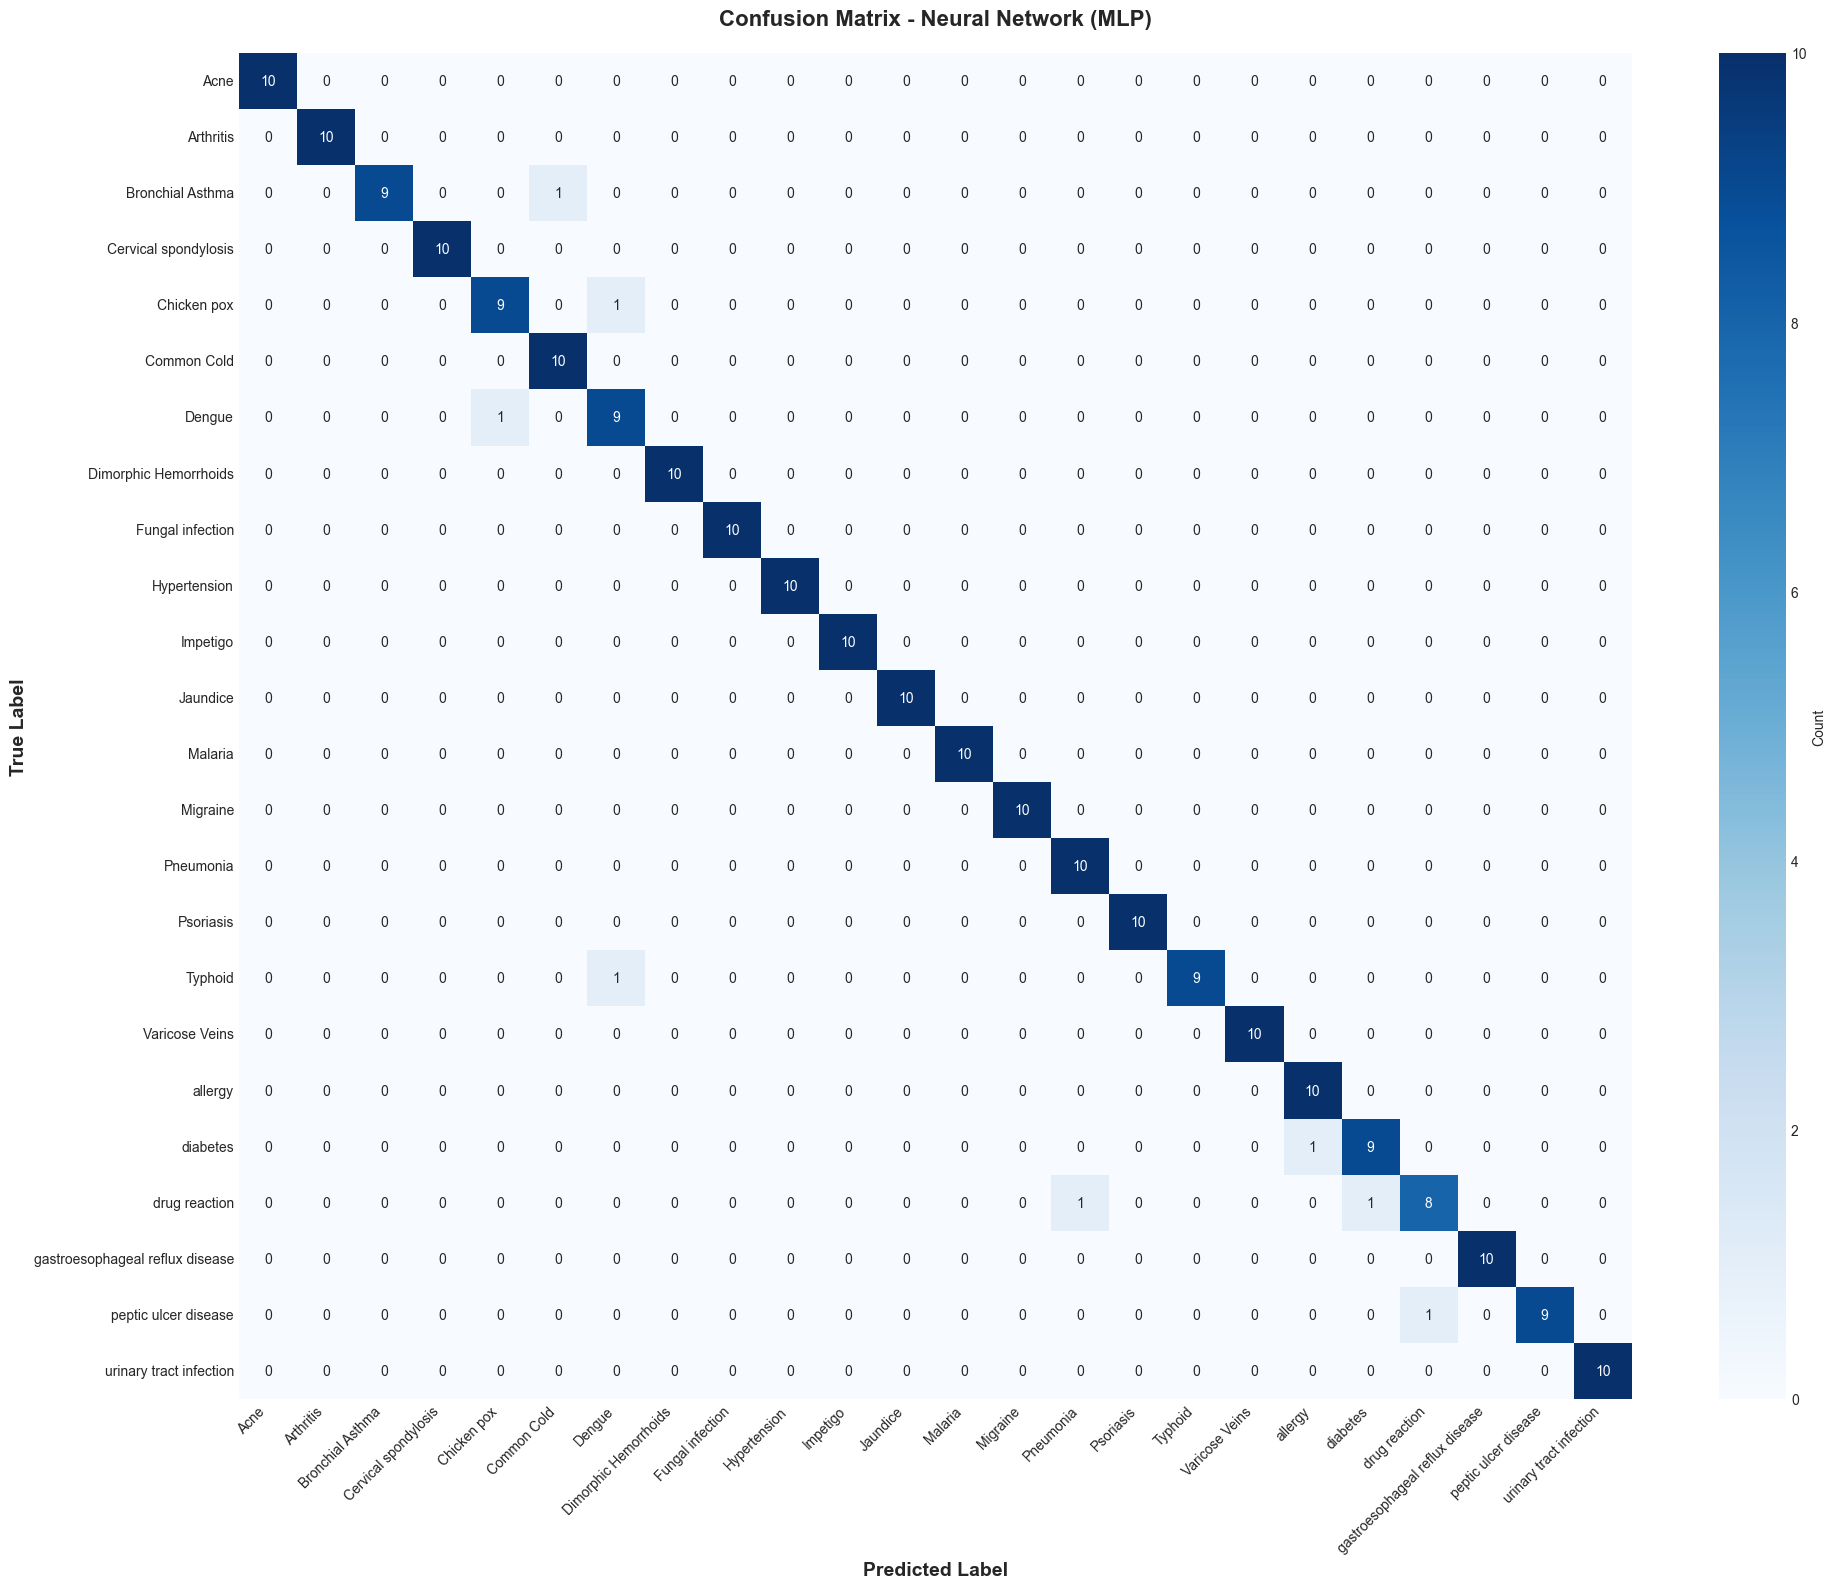

In [58]:
# Plot confusion matrix for MLP model (use mlp_results dict, not the estimator object)
labels_sorted = sorted(y.unique())
cm = confusion_matrix(y_test, mlp_results['y_pred'], labels=labels_sorted)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_sorted,
            yticklabels=labels_sorted,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title(f"Confusion Matrix - {mlp_results['model_name']}", fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
## 9. Save Models and Artifacts

Save all trained models, vectorizers, and necessary artifacts for production use.

In [61]:
# Create models directory if it doesn't exist
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save TF-IDF Vectorizer
joblib.dump(tfidf_vectorizer, f'{models_dir}/tfidf_vectorizer.pkl')
print("TF-IDF Vectorizer saved!")

# Save all models
model_mapping = {
    'logistic_regression': lr_results['model'],
    'linear_svm': svm_results['model'],
    'xgboost': xgb_results['model'],
    'random_forest': rf_results['model'],
    'naive_bayes': nb_results['model'],
    'gradient_boosting': gb_results['model'],
    'neural_network': mlp_results['model']
}

for model_name, model in model_mapping.items():
    joblib.dump(model, f'{models_dir}/{model_name}_model.pkl')
print("All models saved!")

# Save model comparison results
comparison_df.to_csv(f'{models_dir}/model_comparison.csv', index=False)
print("Comparison results saved!")

# Save label encoder information
label_info = {
    'classes': sorted(y.unique().tolist()),
    'num_classes': len(y.unique())
}
with open(f'{models_dir}/label_info.pkl', 'wb') as f:
    pickle.dump(label_info, f)
print("Label information saved!")

# Save model metadata
metadata = {
    'best_model_name': mlp_results['model_name'],
    'best_model_accuracy': mlp_results['accuracy'],
    'best_model_f1_score': mlp_results['f1_score'],
    'training_samples': len(X_train_text),
    'test_samples': len(X_test_text),
    'num_features': X_train.shape[1],
    'num_classes': len(y.unique()),
    'random_state': RANDOM_STATE
}
with open(f'{models_dir}/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("Metadata saved!")

TF-IDF Vectorizer saved!
All models saved!
Comparison results saved!
Label information saved!
Metadata saved!


---
## 10. Model Loading and Prediction Example

Demonstrate how to load saved models and make predictions.

In [60]:
# Example: Load models and make predictions

# Load best model and vectorizer
loaded_model = joblib.load(f'{models_dir}/neural_network_model.pkl')
loaded_vectorizer = joblib.load(f'{models_dir}/tfidf_vectorizer.pkl')
loaded_label_info = pickle.load(open(f'{models_dir}/label_info.pkl', 'rb'))

print("\nModels loaded successfully!")

# Test predictions on new symptom descriptions
test_symptoms = [
    "I have been experiencing severe headache and fever for the past 3 days. My body aches a lot.",
    "I have red itchy rashes all over my body with skin peeling and joint pain.",
    "I have high blood sugar levels and feel very thirsty all the time. I also urinate frequently."
]

for i, symptom in enumerate(test_symptoms, 1):
    # Clean the text
    cleaned_symptom = clean_text(symptom)
    
    # Vectorize
    symptom_vector = loaded_vectorizer.transform([cleaned_symptom])
    
    # Predict
    prediction = loaded_model.predict(symptom_vector)[0]
    
    # Get probability (if available)
    if hasattr(loaded_model, 'predict_proba'):
        probabilities = loaded_model.predict_proba(symptom_vector)[0]
        confidence = max(probabilities) * 100
    else:
        confidence = "N/A"
    
    print(f"\n{'-'*80}")
    print(f"Test Case {i}:")
    print(f"\nSymptoms: {symptom}")
    print(f"\nPredicted Disease: {prediction}")
    if confidence != "N/A":
        print(f"Confidence: {confidence:.2f}%")
    print(f"{'-'*80}")

print("\nPrediction demo completed!")


Models loaded successfully!

--------------------------------------------------------------------------------
Test Case 1:

Symptoms: I have been experiencing severe headache and fever for the past 3 days. My body aches a lot.

Predicted Disease: Dengue
Confidence: 53.47%
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Test Case 2:

Symptoms: I have red itchy rashes all over my body with skin peeling and joint pain.

Predicted Disease: Psoriasis
Confidence: 99.21%
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Test Case 3:

Symptoms: I have high blood sugar levels and feel very thirsty all the time. I also urinate frequently.

Predicted Disease: diabetes
Confidence: 46.31%
--------------------------------------------------------------------------------

Pred